## Imports

In [1]:
import numpy as np
import random
import math

## Rewards and Policies

### Rewards

In [2]:
def create_reward_function(probabilities):
    def reward_function(action):
        return 1 if np.random.rand() < probabilities[action-1] else 0

    return reward_function

### Policies

Random:

In [3]:
def random_bandit_policy(num_actions):
    actions = range(1, num_actions + 1)
    action = random.choice(actions)

    return action

Epsilon greedy:

In [4]:
def epsilon_greedy_policy(q_values, epsilon):
    num_actions = len(q_values)

    if np.random.rand() < epsilon:
        action = np.random.choice(num_actions)  # Explore
    else:
        action = np.argmax(q_values)  # Exploit (pick the action with the highest Q-value)

    action += 1

    return action

UCB:

In [6]:
def ucb_policy(q_values, action_counts, total_steps, c=1):
    num_actions = len(q_values)
    ucb_values = [0] * num_actions
    
    for i in range(num_actions):
        if action_counts[i] > 0:
            exploitation = q_values[i]
            exploration = c * np.sqrt(np.log(total_steps + 1) / action_counts[i])
            ucb_values[i] = exploitation + exploration
        else:
            ucb_values[i] = float('inf')  # Force exploration if action hasn't been taken yet

    action = np.argmax(ucb_values) + 1

    return action

Thompson Sampling:

In [7]:
def thompson_sampling_policy(action_successes, action_failures):
    num_actions = len(action_successes)
    samples = [np.random.beta(action_successes[i] + 1, action_failures[i] + 1) for i in range(num_actions)]
    
    action = np.argmax(samples) + 1

    return action

## Agent

In [9]:
class RL_Agent:
    def __init__(self, num_actions, action_reward_probs, policy, epsilon=None, c=1):
        self.num_actions = num_actions
        self.action_reward_probs = action_reward_probs

        self.reward_function = create_reward_function(action_reward_probs)

        self.policy = policy

        self.c = c  # Exploration parameter for UCB policy
        
        self.epsilon = epsilon  # for epsilon greedy policy
        self.epsilon_decay_rate = 0.998  # Decay rate for epsilon
        self.min_epsilon = 0.05  # Minimum epsilon value
        self.epsilons = []

        self.q_values = np.zeros(num_actions) 
        self.action_counts = np.zeros(num_actions)

        self.rewards = []
        self.regrets = []

        self.action_successes = np.zeros(num_actions)
        self.action_failures = np.zeros(num_actions)
    
    def take_action(self, step):
        if self.policy == "random bandit":
            return random_bandit_policy(self.num_actions)

        elif self.policy == "epsilon greedy":
            # Decay epsilon over time
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay_rate)
            self.epsilons.append(self.epsilon)
                
            return epsilon_greedy_policy(self.q_values, self.epsilon)

        elif self.policy == "ucb":
            return ucb_policy(self.q_values, self.action_counts, step, self.c)

        elif self.policy == "thompson sampling":
            return thompson_sampling_policy(self.action_successes, self.action_failures)
    
    def receive_reward(self, action):
        reward = self.reward_function(action)
        self.rewards.append(reward)
        return reward
    
    def update_q_values(self, action, reward):
        self.action_counts[action-1] += 1
        self.q_values[action-1] += (reward - self.q_values[action-1]) / self.action_counts[action-1]

        if reward == 1:
            self.action_successes[action-1] += 1
        else:
            self.action_failures[action-1] += 1

        self.calculate_regret(reward)

    def calculate_regret(self, reward):
        best_action = np.argmax(self.action_reward_probs)
        best_reward = self.action_reward_probs[best_action]
        regret = best_reward - reward
        self.regrets.append(regret)

## Utitlites

In [10]:
def run(num_steps, agents):
    for step in range(num_steps):
        actions = [agent.take_action(step) for agent in agents]
        rewards = [agent.receive_reward(action) for agent, action in zip(agents, actions)]

        for agent, action, reward in zip(agents, actions, rewards):
            agent.update_q_values(action, reward)

    return [agent.rewards for agent in agents], [agent.regrets for agent in agents]

In [11]:
def cumulating(X):
    sum_X = []
    for i in range(len(X)):
        sum_X.append([])
        for j in range(len(X[i])):
            sum_X[i].append(sum(X[i][0:j]))
    return sum_X

In [20]:
def averaging(X):
    sum_X = []
    for i in range(len(X)):
        sum_X.append([])
        for j in range(len(X[i])):
            sum_X[i].append(sum(X[i][0:j])/(j+1))
    return sum_X

## Run

In [67]:
num_steps = 10000

num_actions = 6 # (569%5) + 2

action_reward_probs = [.1, .9, .9, .5, .6, .9] # 1, otherwise 0

policies_params = {
    "thompson sampling":[None], 
    "ucb":[0.1, 1, 2], 
    "epsilon greedy":[0.1, 0.3, 0.5, 0.8]
}

In [74]:
agents = []

for policy in policies_params:
    for param in policies_params[policy]:
        if policy == "thompson sampling":
            agents.append(RL_Agent(
                num_actions=num_actions,
                action_reward_probs=action_reward_probs,
                policy=policy
            ))
        elif policy == "ucb":
            agents.append(RL_Agent(
                num_actions=num_actions,
                action_reward_probs=action_reward_probs,
                policy=policy, 
                c=param
            ))
        elif policy == "epsilon greedy":
            agents.append(RL_Agent(
                num_actions=num_actions,
                action_reward_probs=action_reward_probs,
                policy=policy, 
                epsilon=param
            ))

In [75]:
rewards, regrets = run(num_steps, agents)

In [76]:
c_rewards = cumulating(rewards)
c_regrets = cumulating(regrets)

In [77]:
a_rewards = averaging(rewards)
a_regrets = averaging(regrets)

## Plots

### Thompson Sampling, UCB, and Epsilon Greedy

#### Cumulative Reward and Regret

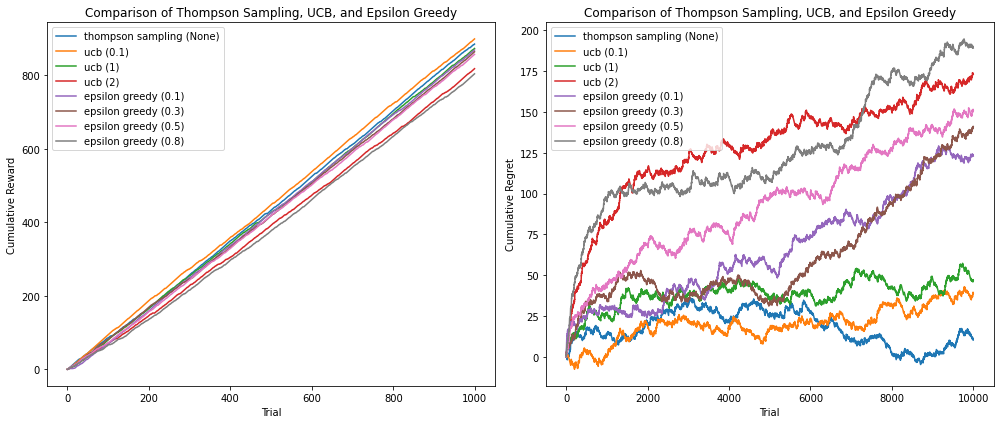

In [78]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot cumulative rewards on the first subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        ax1.plot(c_rewards[num_plot][:1000], label=f"{policy} ({param})")
        num_plot += 1

ax1.set_title("Comparison of Thompson Sampling, UCB, and Epsilon Greedy")
ax1.set_xlabel("Trial")
ax1.set_ylabel("Cumulative Reward")
ax1.legend()

# Plot cumulative regrets on the second subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        ax2.plot(c_regrets[num_plot], label=f"{policy} ({param})")
        num_plot += 1

ax2.set_title("Comparison of Thompson Sampling, UCB, and Epsilon Greedy")
ax2.set_xlabel("Trial")
ax2.set_ylabel("Cumulative Regret")
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


#### Average Reward and Regret

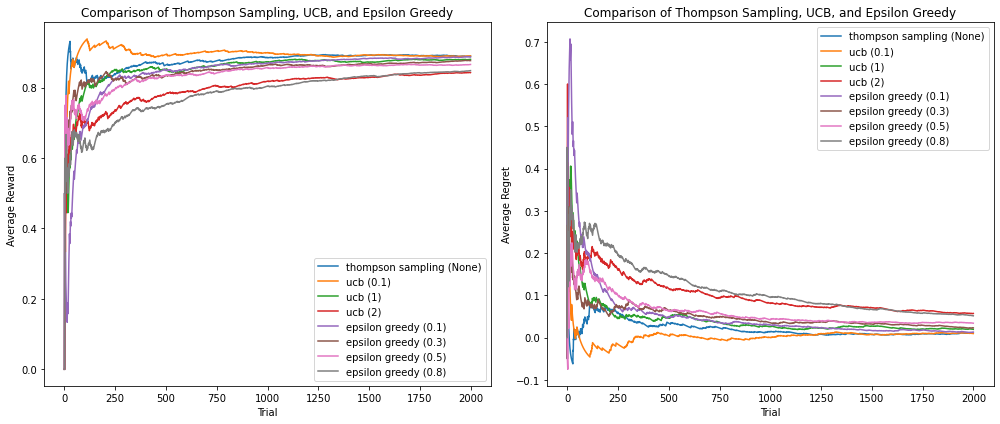

In [87]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot average rewards on the first subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        ax1.plot(a_rewards[num_plot][:2000], label=f"{policy} ({param})")
        num_plot += 1

ax1.set_title("Comparison of Thompson Sampling, UCB, and Epsilon Greedy")
ax1.set_xlabel("Trial")
ax1.set_ylabel("Average Reward")
ax1.legend()

# Plot average regrets on the second subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        ax2.plot(a_regrets[num_plot][:2000], label=f"{policy} ({param})")
        num_plot += 1

ax2.set_title("Comparison of Thompson Sampling, UCB, and Epsilon Greedy")
ax2.set_xlabel("Trial")
ax2.set_ylabel("Average Regret")
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Epsilon Greedy with Different Epsilons

#### Cumulative Reward and Regret

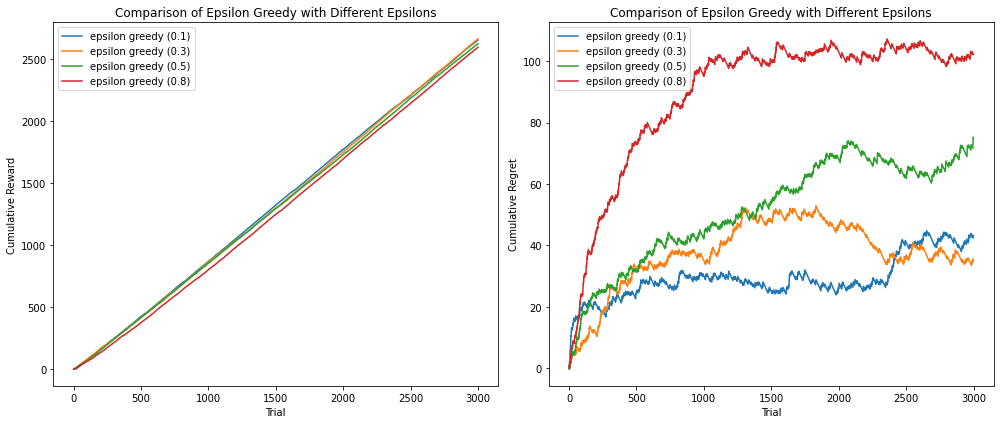

In [85]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot cumulative rewards on the first subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        if policy == "epsilon greedy":
            ax1.plot(c_rewards[num_plot][:3000], label=f"{policy} ({param})")
        num_plot += 1

ax1.set_title("Comparison of Epsilon Greedy with Different Epsilons")
ax1.set_xlabel("Trial")
ax1.set_ylabel("Cumulative Reward")
ax1.legend()

# Plot cumulative regrets on the second subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        if policy == "epsilon greedy":
            ax2.plot(c_regrets[num_plot][:3000], label=f"{policy} ({param})")
        num_plot += 1

ax2.set_title("Comparison of Epsilon Greedy with Different Epsilons")
ax2.set_xlabel("Trial")
ax2.set_ylabel("Cumulative Regret")
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### Average Reward and Regret

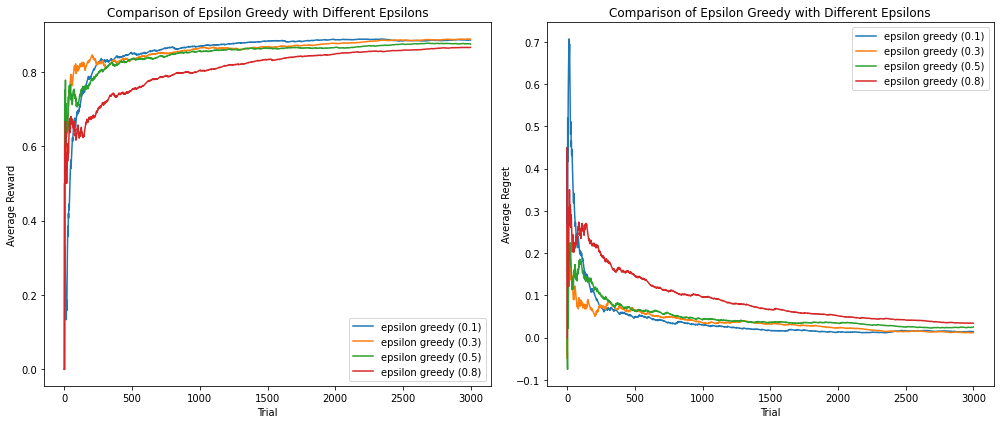

In [84]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot average rewards on the first subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        if policy == "epsilon greedy":
            ax1.plot(a_rewards[num_plot][:3000], label=f"{policy} ({param})")
        num_plot += 1

ax1.set_title("Comparison of Epsilon Greedy with Different Epsilons")
ax1.set_xlabel("Trial")
ax1.set_ylabel("Average Reward")
ax1.legend()

# Plot average regrets on the second subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        if policy == "epsilon greedy":
            ax2.plot(a_regrets[num_plot][:3000], label=f"{policy} ({param})")
        num_plot += 1

ax2.set_title("Comparison of Epsilon Greedy with Different Epsilons")
ax2.set_xlabel("Trial")
ax2.set_ylabel("Average Regret")
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### UCB with different Cs

#### Cumulative Reward and Regret

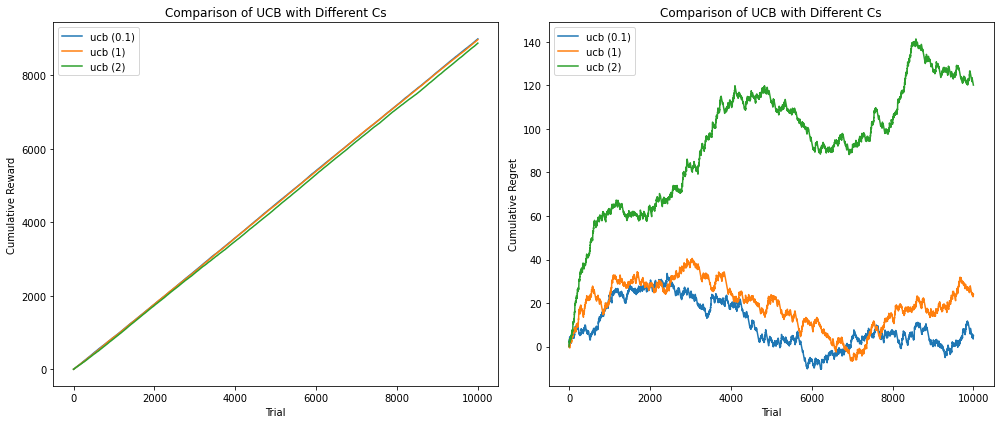

In [65]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot cumulative rewards on the first subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        if policy == "ucb":
            ax1.plot(c_rewards[num_plot], label=f"{policy} ({param})")
        num_plot += 1

ax1.set_title("Comparison of UCB with Different Cs")
ax1.set_xlabel("Trial")
ax1.set_ylabel("Cumulative Reward")
ax1.legend()

# Plot cumulative regrets on the second subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        if policy == "ucb":
            ax2.plot(c_regrets[num_plot], label=f"{policy} ({param})")
        num_plot += 1

ax2.set_title("Comparison of UCB with Different Cs")
ax2.set_xlabel("Trial")
ax2.set_ylabel("Cumulative Regret")
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


#### Average Reward and Regret

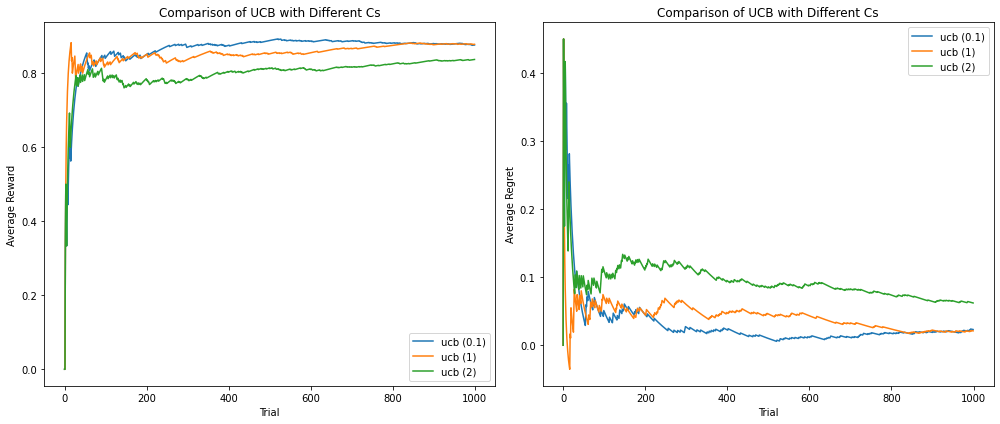

In [66]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot average rewards on the first subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        if policy == "ucb":
            ax1.plot(a_rewards[num_plot][:1000], label=f"{policy} ({param})")
        num_plot += 1

ax1.set_title("Comparison of UCB with Different Cs")
ax1.set_xlabel("Trial")
ax1.set_ylabel("Average Reward")
ax1.legend()

# Plot average regrets on the second subplot
num_plot = 0
for policy in policies_params:
    for param in policies_params[policy]:
        if policy == "ucb":
            ax2.plot(a_regrets[num_plot][:1000], label=f"{policy} ({param})")
        num_plot += 1

ax2.set_title("Comparison of UCB with Different Cs")
ax2.set_xlabel("Trial")
ax2.set_ylabel("Average Regret")
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()